In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from utils.train import *
from utils.dataloader import *
from utils.resnet import resnet34_andi, resnet18_andi

In [6]:
import random
random.seed(42)

dataset_size = 1 # Challenge 150 for classifier, 200 for cp step predictor
num_epochs = 100

device = "cuda"

# Change Point (CP) Detector Dataset Preparation
## from current point, how many "steps" to get "first" change point

In [7]:
X_dict = {f"{feat}":[] for feat in ["feat"]}
y_dict = {f"{feat}":[] for feat in ["cp", "pad"]}

for i in tqdm(range(dataset_size)):

    X = np.load(f"./ds_single/ds_{i}.npy", allow_pickle=True)
    y = np.load(f"./ds_single/ds_label_{i}.npy", allow_pickle=True)
    y_pad = np.load(f"./ds_single/ds_pad_{i}.npy", allow_pickle=True)
    ### TO Tensor
    X = torch.Tensor(X).squeeze().unsqueeze(axis=2).type(torch.Tensor)
    
    y_cp = torch.Tensor(y[:,4])
    y_pad = torch.Tensor(y_pad)
    arg = torch.argwhere(y_cp<200)
    
    X_dict["feat"].append(X[arg].squeeze(dim=1))
    y_dict["cp"].append(y_cp[arg].squeeze(dim=1))
    y_dict["pad"].append(y_pad[arg].squeeze(dim=1))
    
train_dataloader_dict = {f"{feat}":[] for feat in ["cp"]}
valid_dataloader_dict = {f"{feat}":[] for feat in ["cp"]}

g = torch.Generator()
g.manual_seed(42)

for feat in ["cp"]:
    X = X_dict["feat"]
    y = y_dict[feat]
    y_pad = y_dict["pad"]
    X = torch.cat(X)
    y = torch.cat(y)
    y_pad = torch.cat(y_pad)
    y_step = y-y_pad # prev_pad + step
    dataset = AnDiDataset(X, y_step)

    # ## split
    train_set, val_set = torch.utils.data.random_split(dataset, [0.7, 0.3], generator=g)
    
    train_loader = DataLoader(train_set, batch_size=256, collate_fn=collate_fn, generator=g, shuffle=True)
    
    valid_loader = DataLoader(val_set, batch_size=64, collate_fn=collate_fn, generator=g, shuffle=True)

    train_dataloader_dict[f"{feat}"] = train_loader
    valid_dataloader_dict[f"{feat}"] = valid_loader

del X, y, y_pad
import gc
gc.collect()

100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


830

# Model Training : CP Predictor
## Default setting: resnet18(for andi) + custom warmstart scheduler + L1Loss
use 200 dataset for training

Best Model Exist
98 3.564301811153962


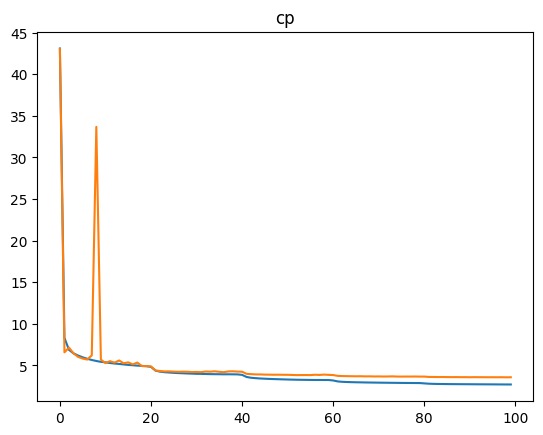

In [8]:
feat = "cp"

model_name=f'predictor_{feat}_step_full_200'


model = resnet18_andi(output_dim=1, output_num=1, problem_type="cp")
criterion = nn.L1Loss()

train_dataloader = train_dataloader_dict["cp"]
valid_dataloader = valid_dataloader_dict["cp"]

model, total_train_loss, total_valid_loss = train(model, train_dataloader, valid_dataloader,
                                                  criterion, 
                                                  # optimizer=optimizer, scheduler=scheduler,
                                                  num_epochs=num_epochs, device=device,  model_name=model_name,
                                                  tag=f"{feat}")
if os.path.exists(f"./model/loss/{model_name}_{feat}.npy") and total_train_loss is None:
    total_train_loss, total_valid_loss = np.load(f"./model/loss/{model_name}_{feat}.npy")
else:
    np.save(f"./model/loss/{model_name}_{feat}.npy", np.array([total_train_loss, total_valid_loss]))

print(np.argmin(total_valid_loss), np.min(total_valid_loss))


plt.plot(total_train_loss)
plt.plot(total_valid_loss)
plt.title(f"{feat}")
plt.show()

# Change Point (CP) Existence Classifier
## Input trajectory has CP or not

In [9]:
X_dict = {f"{feat}":[] for feat in ["feat"]}
y_dict = {f"{feat}":[] for feat in ["cp"]}

for i in tqdm(range(dataset_size)):

    X = np.load(f"./ds_single/ds_{i}.npy", allow_pickle=True)
    y = np.load(f"./ds_single/ds_label_{i}.npy", allow_pickle=True)

    ### TO Tensor
    X = torch.Tensor(X).squeeze().unsqueeze(axis=2).type(torch.Tensor)
    
    y_cp = torch.Tensor(y[:,4])
    y_cp_clf = torch.where(y_cp<200, 1, 0) #cp exist = True, else False
    # print(y_cp, y_cp_clf)
    X_dict["feat"].append(X)
    y_dict["cp"].append(y_cp_clf)

train_dataloader_dict = {f"{feat}":[] for feat in ["cp"]}
valid_dataloader_dict = {f"{feat}":[] for feat in ["cp"]}

g = torch.Generator()
g.manual_seed(42)

for feat in ["cp"]:
    X = X_dict["feat"]
    y = y_dict[feat]
    X = torch.cat(X)
    y = torch.cat(y)
    y = y.type(torch.long)
    dataset = AnDiDataset(X, y)

    # ## split
    train_set, val_set = torch.utils.data.random_split(dataset, [0.7, 0.3], generator=g)
    
    train_loader = DataLoader(train_set, batch_size=256, collate_fn=collate_fn, generator=g, shuffle=True)
    
    valid_loader = DataLoader(val_set, batch_size=64, collate_fn=collate_fn, generator=g, shuffle=True)

    train_dataloader_dict[f"{feat}"] = train_loader
    valid_dataloader_dict[f"{feat}"] = valid_loader

del X, y
import gc
gc.collect()

100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


3705

# Model Training : CP Predictor
## Default setting: resnet34(for andi) + custom warmstart scheduler + L1Loss
use 150 dataset for training

Best Model Exist
27 0.10930371468143298


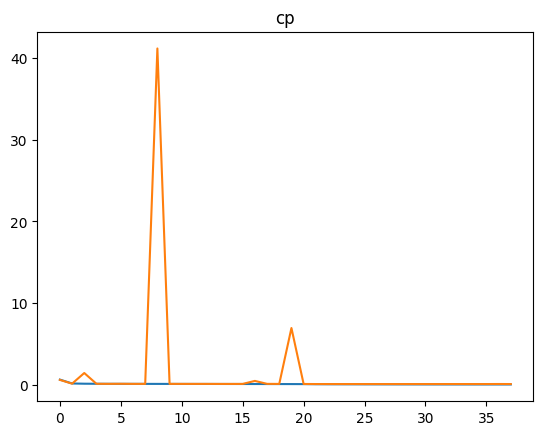

In [10]:
feat = "cp"

model_name=f'classifier_{feat}_full_150'
# resnet34 / Scheduler / CrossEntropyLoss ~ 95%

model = resnet34_andi(output_dim=2, output_num=1, problem_type="s")

criterion = nn.CrossEntropyLoss()


train_dataloader = train_dataloader_dict["cp"]
valid_dataloader = valid_dataloader_dict["cp"]


model, total_train_loss, total_valid_loss = train(model, train_dataloader, valid_dataloader,
                                                  criterion, clf=True,
                                                  # optimizer=optimizer, scheduler=scheduler,
                                                  num_epochs=num_epochs, device=device,  model_name=model_name,
                                                  tag=f"{feat}")
if os.path.exists(f"./model/loss/{model_name}_{feat}.npy") and total_train_loss is None:
    total_train_loss, total_valid_loss = np.load(f"./model/loss/{model_name}_{feat}.npy")
else:
    np.save(f"./model/loss/{model_name}_{feat}.npy", np.array([total_train_loss, total_valid_loss]))

print(np.argmin(total_valid_loss), np.min(total_valid_loss))


plt.plot(total_train_loss)
plt.plot(total_valid_loss)
plt.title(f"{feat}")
plt.show()